In [1]:
#Hello world!
#Welcome to the MK COVID-19 Tracker version Alpha 0.1
#This Notebook is part of the MK COVID-19 Tracker Package, available under MIT licence
#For any feedback and help, please email maksymilian.brzezicki@ndcn.ox.ac.uk
#(MIT) 2020 Nuffield Department of Clinical Neurosciences, University of Oxford, UK

import pandas as pd
import numpy as np
import seaborn as sn
import sqlite3
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter,KaplanMeierFitter, WeibullAFTFitter
from lifelines.plotting import plot_lifetimes  

In [25]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("covid.sql")
df = pd.read_sql_query("SELECT * from labs", con)
con.close()
#TRANSPOSE!

#EVENT OF INTEREST
#Now set the event of interest
for i in range(0,df['ID'].size):
  #  if df['Location'][i]=="Death":
    if df['Location'][i]=="Discharge from ITU" or df['Location'][i]=="Ward" or df['Location'][i]=="Home" :
        df.loc[i,'Location']=1
    #NB in this model, we're only interested in SURVIVING discharge from ITU. Thus, death counts as NEVER leaving the unit (alive)
    #You can remove ED as location (remove all data points) and count people from admission to ITU if you so choose
    elif df['Location'][i]=="ITU" or df['Location'][i]=="ED" or df['Location'][i]=="Death" :
        df.loc[i,'Location']=0
    else:
        print("Error! Please inspect the following locations:")
        print(df.loc[i,'Location'])
    #If you swap to model of death, please uncomment this (below) and comment everything above until #if df['Location'][i]=="Death":
   # else:
    #    df.loc[i,'Location']=0
        
#DATES from absolute to DAYS since first admission

#First let's work out the admission time of all MRNs
listOfAllMRNs=[]
for i in range(0,df['ID'].size):
    listOfAllMRNs.append(df['MRN'][i])

    
#Remove duplicates
listOfAllMRNs=set(listOfAllMRNs)
#Search for earliest date
dictOfAdmDates={}
for i in listOfAllMRNs:
    tempDate=datetime.today()
    for ii in range(0,df['ID'].size):
        if df['MRN'][ii]==i:
            if datetime.strptime(df['Date'][ii], '%Y-%m-%dT%H:%M')<tempDate:
                tempDate=datetime.strptime(df['Date'][ii], '%Y-%m-%dT%H:%M')
    dictOfAdmDates[i]=tempDate

for i in range(0,df['ID'].size):
    z=int((datetime.strptime(df['Date'][i], '%Y-%m-%dT%H:%M')-dictOfAdmDates[df['MRN'][i]]).days)
    if z>=0:
        df.loc[i,'Date']=z
    else:
        print("Error! Please inspect the following dates:")
        print(z)
        print(df.loc[i,'Date'])
     
#Now let's translate modes of vent
        
for i in range(0,df['ID'].size):
    if df['modOfVent'][i]=="Own":
        df.loc[i,'modOfVent']=0
    elif df['modOfVent'][i][:4]=="CPAP":
        df.loc[i,'modOfVent']=1
    elif df['modOfVent'][i][:5]=="BIPAP":
        df.loc[i,'modOfVent']=2
    elif df['modOfVent'][i][:4]=="APRV":
        df.loc[i,'modOfVent']=3
    else:
        print("Error! Please inspect the following modes:")
        print (df['modOfVent'][i])

In [26]:
# Clean unnecessary columns. Here, we did not include any OtherIx of relevance
# Also, there was no routine LDH; Terl was so rare it is severely underpowered for analysis; LofO2 is irrelevant in ITU
# ID will be unneccessary from now on
        
df=df.drop(columns=['ID', 'OtherIx','LDH','LofO2','Terl'])


In [27]:
#This line will save the modified dataset for export and analysis in other apps, like SPSS or Excel.
#Please specify your path for the file
dfToSave=df.copy()
dfToSave=dfToSave.drop(columns=['MRN'])
#Useful for removing empty boxes, last operations before export:
for i in range(0,dfToSave['Ddimer'].size):
    if dfToSave['Ddimer'][i]==0:
        dfToSave.loc[i,'Ddimer']=None
        
dfToSave.to_csv(r'C:\Users\TurtlePC\Desktop\export_dataframe.csv', index = True)

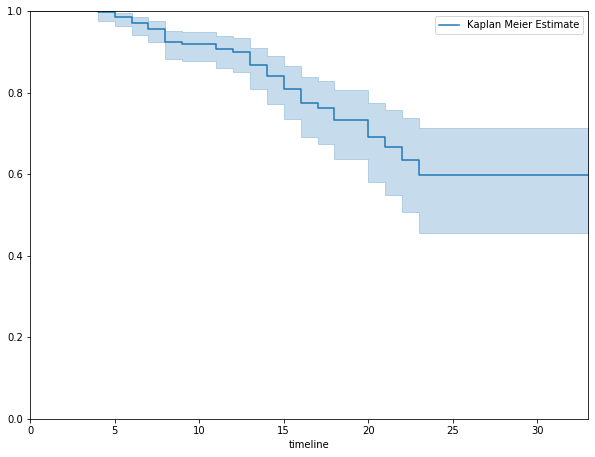

In [28]:
#KM Curve Estimate for the event of choice, default: Probability of NEVER leaving the unit ALIVE
durations = df['Date'] ## Time to event
event_observed = df['Location']  ## If the event has happened it is: (1) and if not (censored) it is: (0)
km = KaplanMeierFitter()

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')
plt.subplots(figsize=(10,7.5))
## Create an estimate
plt.ylim(0, 1)   
#Above is optional to set the Y axis limits
km.plot()


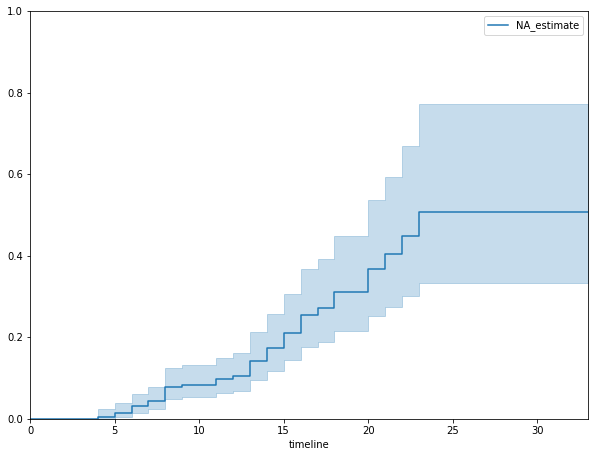

In [29]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
plt.subplots(figsize=(10,7.5))
naf.fit(durations, event_observed)
plt.ylim(0, 1) 
naf.plot()


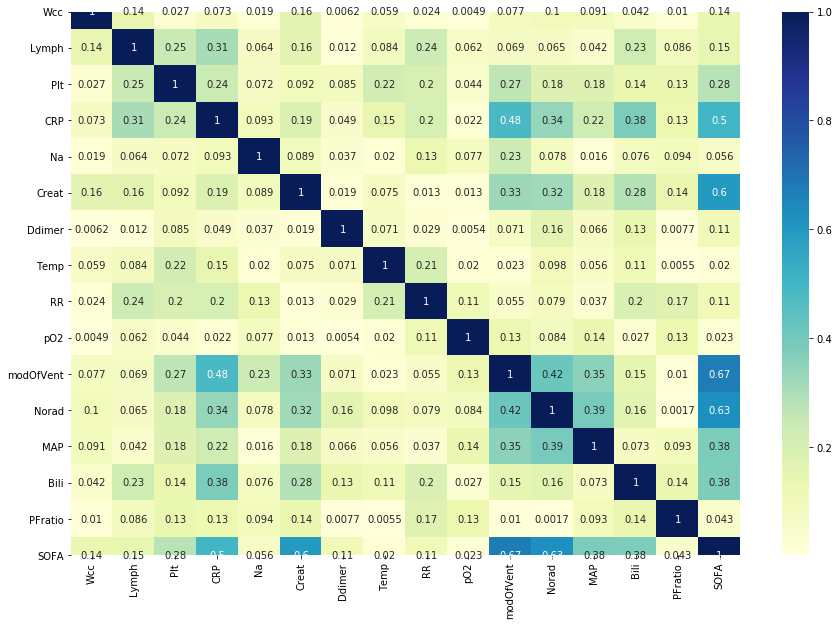

In [36]:
#Now let's have a look at the correlations
dfCorr=df.copy()
dfCorr=dfCorr.drop(columns=['Date','Location'])
corrMatrix = dfCorr.corr().abs()
plt.subplots(figsize=(15,10))
sn.heatmap(corrMatrix, annot=True,cmap="YlGnBu")
plt.show()

In [9]:
#Now this is a must for modelling: no ZERO durations as allowed; let's make it 0.01
for i in range(0,df['Date'].size):
    if df.loc[i,'Date']==0:
         df.loc[i,'Date']=0.01

In [10]:

#NB these have been pre-selected to exclude massive skewers from above; please feel free to add/remove
df1=df[['Date','Location','Wcc','Lymph','Plt','CRP','Na','Creat','Ddimer','Temp','RR','pO2','MAP','Bili','PFratio','PctgO2','SOFA','modOfVent']]
aft = WeibullAFTFitter(penalizer=0.1)
aft.fit(df1, 'Date', event_col='Location')

aft.print_summary(3)

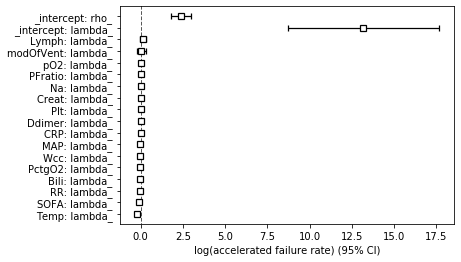

In [11]:
aft.plot()

In [12]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

28.795275502754098
28.42975524439563


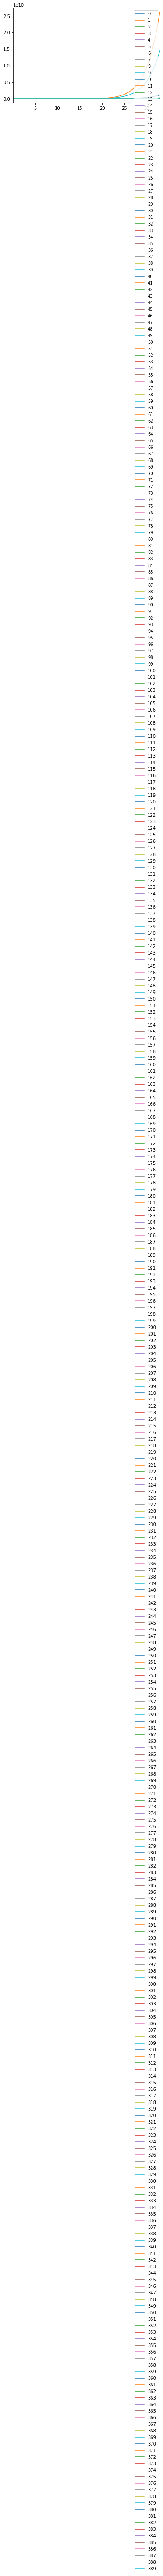

In [13]:
aft.predict_cumulative_hazard(df1).plot()

In [14]:
# Using Cox Proportional Hazards model
# You can exclude some columns at this point
df2=df1.copy()

cph = CoxPHFitter()   
cph.fit(df2, 'Date', event_col='Location')   
cph.print_summary()    

c:\users\turtlepc\appdata\local\programs\python\python37\lib\site-packages\lifelines\fitters\coxph_fitter.py:707: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently in 500 steps.

  "Newton-Rhaphson failed to converge sufficiently in %d steps.\n" % max_steps, ConvergenceWarning


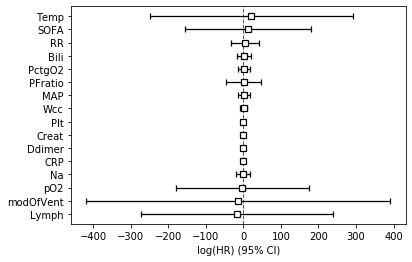

In [15]:
cph.plot()

In [49]:
#Let's try to predict survival using some made-up numbers
du1=df1.loc[99]
du1['Wcc']=15
du1['Lymph']=0.3
du1['Plt']=400
du1['CRP']=173
du1['Na']=119
du1['Creat']=44
du1['Ddimer']=0
du1['Temp']=38.5
du1['RR']=26
du1['PctgO2']=100
du1['Date']=5
du1['Location']=0
du1['pO2']=9
du1['modOfVent']=0 #Own=0, CPAP=1, BIPAP=2, APRV=3
du1['Norad']=0
du1['MAP']=92
du1['Bili']=28
du1['PFratio']=du1['pO2']/(du1['PctgO2']/100)
du1['SOFA']=2
print(du1)

Date            5
Location        0
Wcc            15
Lymph         0.3
Plt           400
CRP           173
Na            119
Creat          44
Ddimer          0
Temp         38.5
RR             26
pO2             9
MAP            92
Bili           28
PFratio         9
PctgO2        100
SOFA            2
modOfVent       0
Norad           0
Name: 99, dtype: object


c:\users\turtlepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\turtlepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\turtlepc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

Date            5
Location        0
Wcc            15
Lymph         0.3
Plt           400
CRP           173
Na            119
Creat          44
Ddimer          0
Temp         38.5
RR             26
pO2             9
MAP            92
Bili           28
PFratio         9
PctgO2        100
SOFA            2
modOfVent       0
Norad           0
Name: 99, dtype: object


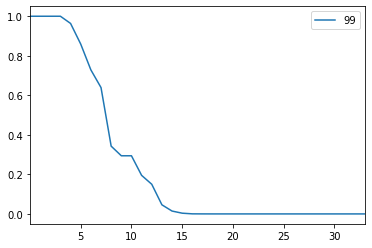

In [50]:
cph.predict_survival_function(du1).plot()
print(du1)

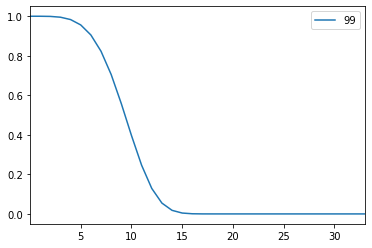

In [51]:
aft.predict_survival_function(du1).plot()